In [1]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow.keras.backend as K
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
SIZE=256
def read_image_tf(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (SIZE, SIZE))
    x = x / 255.0
    return x.astype(np.float32)

def read_mask_tf(path):
    path = path.decode()
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (SIZE, SIZE))
    y[y != 0] = 255
    y = y / 255.0
    y = (y > 0.5).astype(np.float32)
    y = np.expand_dims(y, axis=-1)
    return y

def tf_parse(x_path, y_path):
    def _parse(x_path, y_path):
        x = read_image_tf(x_path)
        y = read_mask_tf(y_path)
        return x, y

    x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float32, tf.float32])
    x.set_shape([SIZE, SIZE, 3])
    y.set_shape([SIZE, SIZE, 1])
    return x, y

def tf_dataset(x_paths, y_paths, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [4]:
def iou(y_true, y_pred):
    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15)
    return iou

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [5]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
    TensorBoard()
]

In [6]:
weight_decay=1e-8

def conv_block(x, filters, dropout=False):
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.5)(x)

    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

In [7]:
train_y = '/content/drive/MyDrive/PFA_Final/new_data/train/GT_TE'
train_x = '/content/drive/MyDrive/PFA_Final/new_data/train/images'
test_y = '/content/drive/MyDrive/PFA_Final/new_data/test/GT_TE'
test_x = '/content/drive/MyDrive/PFA_Final/new_data/test/images'
valid_y = '/content/drive/MyDrive/PFA_Final/new_data/valid/GT_TE'
valid_x = '/content/drive/MyDrive/PFA_Final/new_data/valid/images'

train_images = sorted(glob(os.path.join(train_x, "*.bmp")))
train_masks  = sorted(glob(os.path.join(train_y, "*.bmp")))

test_images = sorted(glob(os.path.join(test_x, "*.bmp")))
test_masks  = sorted(glob(os.path.join(test_y, "*.bmp")))

valid_images = sorted(glob(os.path.join(valid_x, "*.bmp")))
valid_masks  = sorted(glob(os.path.join(valid_y, "*.bmp")))

# Create datasets
train_dataset = tf_dataset(train_images, train_masks, batch_size=16)
test_dataset  = tf_dataset(test_images, test_masks, batch_size=16,shuffle=False)
valid_dataset = tf_dataset(valid_images, valid_masks, batch_size=16, shuffle=False)
print("Number of training samples:", len(train_images))
print("Number of validation samples:", len(valid_images))
print("Number of testing samples:", len(test_images))

metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]

Number of training samples: 995
Number of validation samples: 25
Number of testing samples: 25


In [8]:
# image sequentialization: shaping the input x into a sequence of flattened 2D patches
def patch_embedding(x, patch_size, embed_dim):
    x = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(x)
    # (B, H/P, W/P, D=embed_dim), reshaped to (B, N, D), N=H*W/P²
    x = layers.Reshape((-1, embed_dim))(x)
    return x

def transformer_block(x, embed_dim, num_heads, mlp_dim, dropout=0.1, return_attention=False):
    norm1 = layers.LayerNormalization(epsilon=1e-6)(x)
    mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)

    if return_attention:
        attn_output, attn_scores = mha(norm1, norm1, return_attention_scores=True)
    else:
        attn_output = mha(norm1, norm1)

    x = layers.Add()([x, attn_output])

    norm2 = layers.LayerNormalization(epsilon=1e-6)(x)
    mlp_output = layers.Dense(mlp_dim, activation='gelu')(norm2)
    mlp_output = layers.Dropout(dropout)(mlp_output)
    mlp_output = layers.Dense(embed_dim)(mlp_output)
    mlp_output = layers.Dropout(dropout)(mlp_output)
    x = layers.Add()([x, mlp_output])

    if return_attention:
        return x, attn_scores
    return x

def transformer_bottleneck(x, patch_size=1, num_layers=4, embed_dim=512, num_heads=8, mlp_dim=1024, return_all_attention=False):
    h, w, c = x.shape[1:]

    # Image Sequentialization.
    x = patch_embedding(x, patch_size, embed_dim)  # (B, N, D)

    # Positional encoding
    pos_emb = tf.Variable(tf.random.normal([1, x.shape[1], embed_dim]), trainable=True)

    # Patch Embedding.
    x = x + pos_emb

    attn_maps = []  # Store attention scores if needed
    for _ in range(num_layers):
        if return_all_attention:
            x, attn = transformer_block(x, embed_dim, num_heads, mlp_dim, return_attention=True)
            attn_maps.append(attn)
        else:
            x = transformer_block(x, embed_dim, num_heads, mlp_dim)

    # Reshape back to 2D
    new_h, new_w = h // patch_size, w // patch_size
    x = layers.Reshape((new_h, new_w, embed_dim))(x)

    if return_all_attention:
        return x, attn_maps
    return x

def build_transunet(input_shape, return_attention=False):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Transformer bottleneck
    if return_attention:
        b1, attention_maps = transformer_bottleneck(p4, patch_size=1, num_layers=4,
                                                    embed_dim=512, num_heads=8,
                                                    mlp_dim=1024, return_all_attention=True)
    else:
        b1 = transformer_bottleneck(p4, patch_size=1, num_layers=4,
                                    embed_dim=512, num_heads=8,
                                    mlp_dim=1024, return_all_attention=False)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    if return_attention:
        return Model(inputs, [outputs, attention_maps])
    return Model(inputs, outputs)

In [9]:
input_shape = ((SIZE, SIZE, 3))
model = build_transunet(input_shape, return_attention=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=metrics)
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=300,
    callbacks=callbacks
)

Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.6444 - dice_coef: 0.3578 - iou: 0.2727 - loss: 0.6423 - precision: 0.2532 - recall: 0.9155 - val_accuracy: 0.6946 - val_dice_coef: 0.2991 - val_iou: 0.2325 - val_loss: 0.6974 - val_precision: 0.2513 - val_recall: 0.7768 - learning_rate: 1.0000e-04
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9227 - dice_coef: 0.6136 - iou: 0.5843 - loss: 0.3865 - precision: 0.6203 - recall: 0.9074 - val_accuracy: 0.8984 - val_dice_coef: 0.4479 - val_iou: 0.4399 - val_loss: 0.5457 - val_precision: 0.5648 - val_recall: 0.6803 - learning_rate: 1.0000e-04
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9429 - dice_coef: 0.6759 - iou: 0.6509 - loss: 0.3241 - precision: 0.7041 - recall: 0.8954 - val_accuracy: 0.8808 - val_dice_coef: 0.1377 - val_iou: 0.0209 - val_loss: 0.8552 - val_precision: 0.6109 - val_recall: 0.0270 - learning_rate: 1.0000e-04
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accurac

In [10]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9677 - dice_coef: 0.8723 - iou: 0.7756 - loss: 0.1293 - precision: 0.8694 - recall: 0.8739


[0.12721557915210724,
 0.875232458114624,
 0.7801980972290039,
 0.9686358571052551,
 0.8761310577392578,
 0.8710811734199524]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


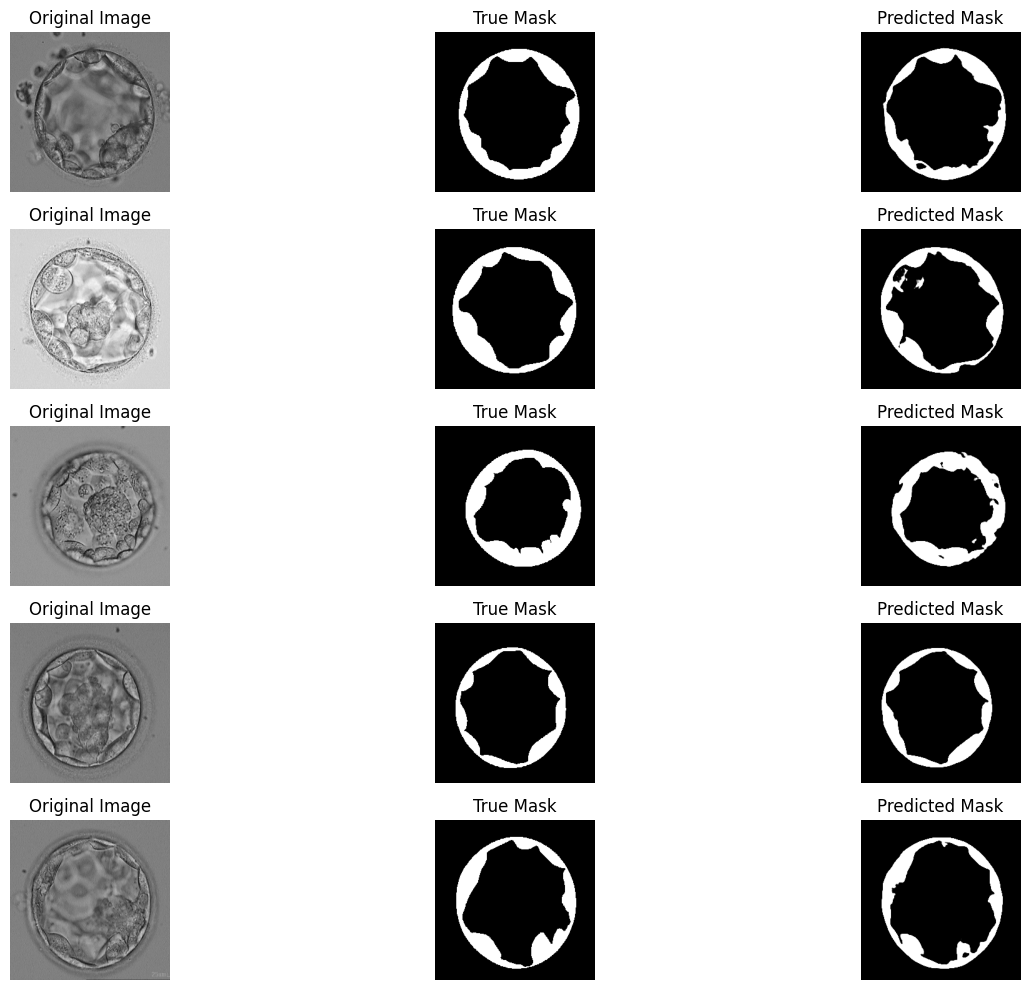

In [11]:
# Make predictions on a batch of test images
test_batch = next(iter(test_dataset))
test_images_batch, test_masks_batch = test_batch

predictions = model.predict(test_images_batch)

num_samples = 5
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    # Original Image
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(test_images_batch[i])
    plt.title("Original Image")
    plt.axis('off')

    # True Mask
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(np.squeeze(test_masks_batch[i]), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(np.squeeze(predictions[i]), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()